In [192]:
## Contents

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [193]:
import arff
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

data=arff.load(open('1year.arff'))
data=pd.DataFrame(np.array(data['data']))
data=data.drop([26,20,36,10], axis=1)

data=data.dropna(axis=0)
data=data.convert_objects(convert_numeric=True)

crupt_data = data[data[64] == 1]
uncrupt_data=data[data[64]==0]

processed_data=uncrupt_data
for i in range(5):
    processed_data=processed_data.append(crupt_data)

response=[64]
predictor_list=[i for i in data.columns.values.tolist() if i not in response]

y=processed_data[64]
X=processed_data[predictor_list]


classifier = LogisticRegression(random_state=0,penalty="l1")
pd.DataFrame(classifier.fit(X, y).coef_)



/Users/qiankunhuang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-3.163572,-0.148658,-1.113434,-0.07252,-0.000001,0.328009,-2.398023,-0.089499,-0.152512,-0.062503,...,4.986895e-09,0.016169,-0.018174,-0.023743,-0.002108,-0.000064,0.000735,0.000001,-0.034619,-0.000877


In [194]:
print "Num of rows: " + str(X.shape[0]) # row count
print "Num of columns: " + str(X.shape[1]) # col count

Num of rows: 7626
Num of columns: 60


### Part 1.2: Data cleaning

Remove Extra Whitespace

In [195]:

print (X.describe())


                0            1            2            3              4   \
count  7626.000000  7626.000000  7626.000000  7626.000000    7626.000000   
mean      0.093268     0.528058     0.161425     2.327136     211.333924   
std       0.161257     0.327771     0.324226     4.199151   15393.772459   
min      -1.186200     0.004765   -10.036000     0.060713 -102660.000000   
25%       0.015301     0.314260     0.008281     1.016825     -49.293500   
50%       0.066619     0.508415     0.160460     1.420450     -10.955500   
75%       0.147328     0.703982     0.347100     2.319650      30.962500   
max       1.994300    10.759000     0.951800   163.890000  990900.000000   

                5            6            7            8            9   \
count  7626.000000  7626.000000  7626.000000  7626.000000  7626.000000   
mean      0.050777     0.110932     2.257132     1.753287     0.447563   
std       0.517107     0.176035     6.134299     1.511093     0.334422   
min     -37.292000 

### Part 1.3:  Understand the features

In [196]:
print (X.shape)

(7626, 60)


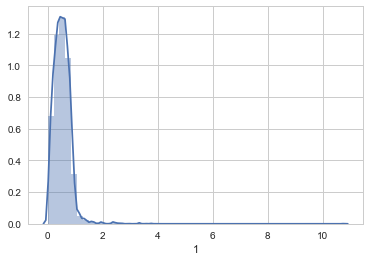

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.distplot(X[1])

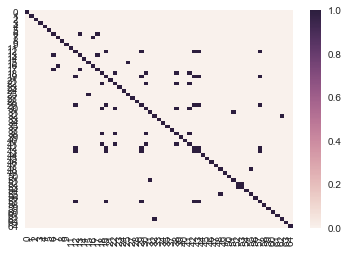

In [198]:
corr = processed_data.corr()
sb.heatmap(corr>0.99)



# Part 2: Feature Preprocessing

In [199]:
A_ir=[]
A_r=[]
A_rv=[]
for i in xrange(65):
    if i not in [26,20,36,10]:
        if abs(corr[64][i])<0.001:
            A_ir.append(i)
        else:
            continue
    else:
        continue
        
for i in xrange(65):
    if i not in [26,20,36,10]:
        if abs(corr[64][i])>0.1:
            A_rv.append(i)
        else:
            continue
    else:
        continue

for i in xrange(65):
    for j in xrange(65):
           if i not in [26,20,36,10] and j not in [26,20,36,10]:
                if abs(corr[i][j])>0.99 and j!=i:
                    if (j,i) not in A_r:
                        A_r.append((i,j))
                    else:
                         continue 
                else:
                    continue
print A_ir
print A_r
print A_rv


[]
[(6, 13), (6, 17), (7, 16), (12, 19), (12, 29), (12, 42), (12, 43), (12, 48), (12, 55), (12, 57), (13, 17), (15, 25), (18, 22), (18, 30), (18, 38), (18, 41), (19, 29), (19, 42), (19, 43), (19, 48), (19, 55), (19, 57), (22, 30), (22, 38), (22, 41), (29, 42), (29, 43), (29, 48), (29, 55), (29, 57), (30, 38), (30, 41), (31, 51), (32, 62), (38, 41), (42, 43), (42, 48), (42, 55), (42, 57), (43, 48), (43, 55), (43, 57), (48, 55), (48, 57), (52, 53), (55, 57)]
[0, 1, 2, 6, 9, 13, 17, 21, 23, 24, 34, 37, 50, 64]


In [200]:
# Get ground truth data
y= y.as_matrix().astype(np.float)
x= X.as_matrix().astype(np.float)
# Converts data frame to its Numpy-array representation.



In [201]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % x.shape
print "Unique target labels:", np.unique(y)
#(X-U)/sigma 减小误差


Feature space holds 7626 observations and 60 features
Unique target labels: [ 0.  1.]


# Part 3: Model Training and Result Evaluation

### Part 3.1: K-fold Cross-Validation

In [202]:
from sklearn.cross_validation import KFold
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

### Part 3.2: Run Supervised Learning Models and Calculate Accuracy

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.


LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5
SVM_CV_result=run_cv(X,y,SVC)
print SVM_CV_result.shape

(7626,)


In [204]:
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result))
print "SVM" + str(accuracy(y,SVM_CV_result))


Logistic Regression (L2 is default): 0.837529504327
Random forest: 0.992918961448
K-nearest-neighbors: 0.88106477839
SVM0.847626540782


Part 3.3: Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [205]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print classifier
    print "Accuracy is " + str(accuracy)
    print "Precision is " + str(precision)
    print "Recall is " + str(recall)

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ("Random Forest", confusion_matrix(y,RF_CV_result)),
    ("K-Nearest-Neighbors", confusion_matrix(y,KNN_CV_result)),
    ("Logisitic Regression", confusion_matrix(y,LR_CV_result)),
     ("SVM", confusion_matrix(y,SVM_CV_result))]

Random Forest
Accuracy is 0.992918961448
Precision is 0.992768432636
Recall is 0.998734777795


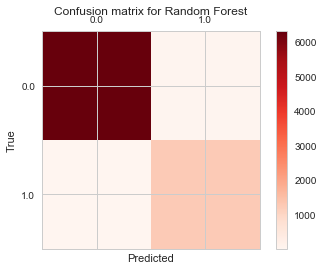

K-Nearest-Neighbors
Accuracy is 0.88106477839
Precision is 0.885080962113
Recall is 0.969686531175


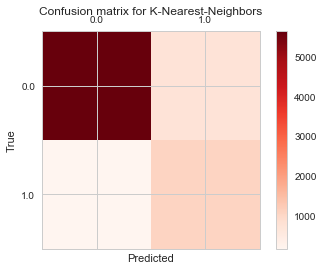

Logisitic Regression
Accuracy is 0.837529504327
Precision is 0.979562961798
Recall is 0.848910081744


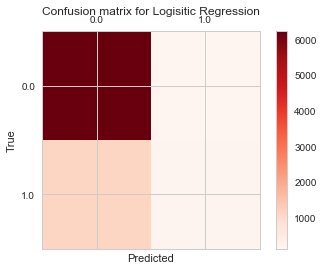

SVM
Accuracy is 0.847626540782
Precision is 0.997641880208
Recall is 0.846923795543


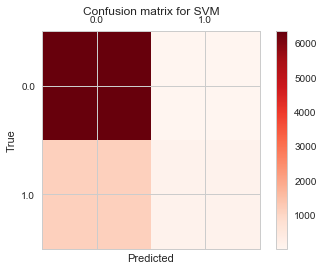

In [206]:
%matplotlib inline
draw_confusion_matrices(confusion_matrices,class_names)

In [207]:
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), processed_data.columns), reverse=True):
    print v , str(k)

Feature importance ranking by Random Forest Model:
23 0.0517
45 0.0399
12 0.0334
4 0.0316
3 0.0256
44 0.0237
63 0.0219
25 0.0208
18 0.0204
48 0.0203
6 0.019
5 0.0188
40 0.0187
14 0.0186
28 0.0182
2 0.0179
34 0.0178
21 0.0178
15 0.0176
33 0.0174
11 0.0174
39 0.0169
24 0.0169
0 0.0169
8 0.0168
41 0.0164
35 0.0164
13 0.0164
57 0.0163
29 0.0157
49 0.0153
54 0.0151
37 0.0149
47 0.0147
27 0.0145
56 0.0143
46 0.0142
43 0.0142
1 0.0141
30 0.0137
52 0.0134
60 0.0131
22 0.0131
7 0.0125
53 0.0121
9 0.0121
19 0.012
58 0.0116
38 0.0115
55 0.0114
32 0.0113
62 0.0106
50 0.0104
61 0.0103
17 0.0103
51 0.0096
16 0.0095
42 0.0086
59 0.0084
31 0.006


In [208]:
LRmodel_l1 = LogisticRegression(penalty="l1")
LRmodel_l1.fit(X, y)
LRmodel_l1.coef_[0]
print "Logistic Regression (L1) Coefficients"
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), 
                      processed_data.columns), key=lambda (k,v):(-abs(k),v)):
    print v ,str(k)

Logistic Regression (L1) Coefficients
62 -8.622
32 7.0729
47 2.7299
49 2.1145
51 -1.9759
15 1.5284
50 -1.5153
37 -1.3734
16 -1.1745
44 1.0505
45 -1.0095
33 0.9407
23 -0.9401
9 0.9129
1 0.8359
3 -0.6685
0 -0.6576
11 -0.6402
40 -0.5514
2 -0.5494
39 0.4263
17 -0.3499
8 -0.3414
21 -0.3275
35 0.3233
6 -0.213
14 0.2044
53 -0.197
34 -0.1707
56 -0.1618
59 -0.1584
18 -0.1263
13 -0.1108
5 0.1089
28 -0.0785
46 0.0725
24 0.0553
63 -0.0475
54 0.0204
4 -0.0185
58 -0.0172
52 0.0156
60 0.0008
7 0.0
12 0.0
19 0.0
22 0.0
25 0.0
27 0.0
29 0.0
30 0.0
31 0.0
38 0.0
41 0.0
42 0.0
43 0.0
48 0.0
55 0.0
57 0.0
61 0.0
